In [1]:
pip install unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
from unet import UNet

In [3]:
'''
At any arbitrary time-step we can write
x_t = sqrt(alpha_mean)*x0 + sqrt(1-alpha_mean)*epsilon

mean = sqrt(a_hat_t)*x_0
variance = sqrt(1-a_hat_t)*random_noise

x_t = mean + variance
'''

'\nAt any arbitrary time-step we can write\nx_t = sqrt(alpha_mean)*x0 + sqrt(1-alpha_mean)*epsilon\n\nmean = sqrt(a_hat_t)*x_0\nvariance = sqrt(1-a_hat_t)*random_noise\n\nx_t = mean + variance\n'

In [4]:
# Random input

x0 = torch.randn(2,3,32,32) # batch, channel, imgximg
x0 = torch.randn(2,10) # batch, #feats

# Variance schedule (linear) , forward process.

betas = torch.tensor([0.005, 0.1, 0.15, 0.2, 0.25])

# Timestep (we want to take x_t at t = 1 and t = 3)
# Timestep corrospond to the batch size ?

t = torch.tensor([1,3])

In [5]:
# betas -> amounts of noise that are being applied at every timestep of the diffusion process.
# alphas -> (1-betas) -> amount of original image's information that is being preserved. 

alphas = 1- betas
alphas

tensor([0.9950, 0.9000, 0.8500, 0.8000, 0.7500])

In [6]:
# cummalative product
alpha_hat = torch.cumprod(alphas,axis = 0) 
# alpha_hat = tensor([0.9950, 0.8955, 0.7612, 0.6089, 0.4567])
# take out the values of alpha_hat that corrospond to the timesteps
result = alpha_hat.gather(-1,t)
# result = tensor([0.8955, 0.6089])
# reshape to the dimmension of the input
result = result.reshape(-1,1)
# result = tensor([[0.8955],[0.6089]])

In [7]:
noise = torch.rand_like(x0)
mean = result.sqrt()*x0
variance = torch.sqrt(1-result)*noise

In [8]:
x_t = mean + variance

# x_t will have 2 images
# x_t[0] and x_t[1]
# 1 at timestep 1 with less noise
# and 2 at timestep 3 with more noise.

In [9]:
def forward_diffusion(x0, t, betas = torch.linspace(0.0,1.0,40)):
  noise = torch.rand_like(x0)
  alphas = 1- betas
  alpha_hat = torch.cumprod(alphas, axis = 0)
  result = alpha_hat.gather(-1,t).reshape(-1,1)

  mean = result.sqrt()*x0
  variance = torch.sqrt(1-result)*noise
  return mean +variance, noise

In [39]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
   
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
      
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
  
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs)[0] / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())

        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [41]:
diffusion_model = DiffusionModel()

In [42]:
inp = torch.randn(200)

#t = torch.tensor([0,1,2,3,39])
batch_images = torch.stack([inp]*5)

In [43]:
diffusion_model.timesteps

300

In [44]:
NO_DISPLAY_IMAGES = 5
device = 'cpu'
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(batch_images, t, device)


In [45]:
noisy_image_batch.shape

torch.Size([5, 200])

In [81]:
t

tensor([  0,  74, 149, 224, 299])

In [16]:
for idx, image in enumerate(noisy_image_batch):
  print(t[idx].item())

0
74
149
224
299


In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [18]:
embd = SinusoidalPositionEmbeddings(5)
embd.forward(t)

tensor([[ 0.0000,  0.0000,  1.0000,  1.0000],
        [-0.9851,  0.0074,  0.1717,  1.0000],
        [-0.9746,  0.0149, -0.2237,  0.9999],
        [-0.8116,  0.0224, -0.5842,  0.9997],
        [-0.5216,  0.0299, -0.8532,  0.9996]])

In [46]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        print('Im him')
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample
        
        if downsample:
            self.lin1 = nn.Linear(channels_in, channels_out)
            self.final = nn.Linear(channels_out, channels_out)
        else:
            self.lin1 = nn.Linear(2*channels_in, channels_out)
            self.final = nn.Linear(channels_out, channels_out)
        
        
        self.lin2 = nn.Linear(channels_out, channels_out)


        self.bnorm1 = nn.BatchNorm1d(channels_out)
        self.bnorm2 = nn.BatchNorm1d(channels_out)
        
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):

        try:
          o = self.bnorm1(self.relu(self.lin1(x)))
        except:
          o = self.relu(self.lin1(x))

        o_time = self.relu(self.time_mlp(self.time_embedding(t)))

        o = o + o_time
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label
   
        try:
          o = self.bnorm2(self.relu(self.lin2(o)))
        except:
          o = self.relu(self.lin2(o))

        return self.final(o)


In [131]:
class UNet(nn.Module):
    def __init__(self, img_channels = 200, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512)):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        
        #self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.lin1 = nn.Linear(img_channels, sequence_channels[0])
        #self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)
        self.lin2 = nn.Linear(sequence_channels[0], img_channels)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.lin1(x)
        
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)   
        
        return self.lin2(o)

In [20]:
def kl_divergence(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
   
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)

    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum(-1)
    return kl

In [28]:
class UNet_plus(nn.Module):
    def __init__(self, img_channels = 200, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512)):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        
        #self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.lin1 = nn.Linear(img_channels, sequence_channels[0])
        #self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)
        #self.lin2 = nn.Linear(sequence_channels[0], img_channels)

        self.mu = nn.Linear(sequence_channels[0], img_channels)
        self.var = nn.Linear(sequence_channels[0], img_channels)
    
    def forward(self, x, t, **kwargs):

        residuals = []
        o = self.lin1(x)
        
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)   
        
        #self.lin2(o)
        
        z_mu = self.mu(o)
        z_var = self.var(o)

        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = x_sample #torch.cat((x_sample,y), dim=1)

        return z, z_mu, z_var

In [29]:
NO_EPOCHS = 1000
PRINT_FREQUENCY = 500
LR = 0.0001
BATCH_SIZE = 2
VERBOSE = True

unet = UNet_plus(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

Im him
Im him
Im him
Im him
Im him
Im him


In [33]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

---
Epoch: 0 | Train Loss 21.82010269165039


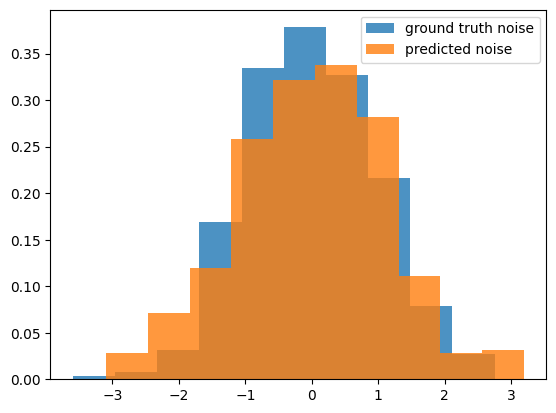

---
Epoch: 500 | Train Loss 0.44627904891967773


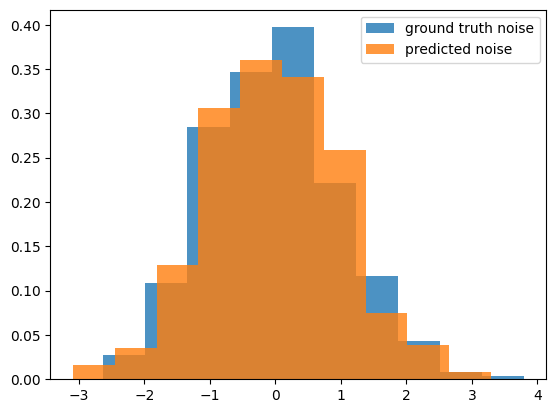

---
Epoch: 1000 | Train Loss 0.2846342921257019


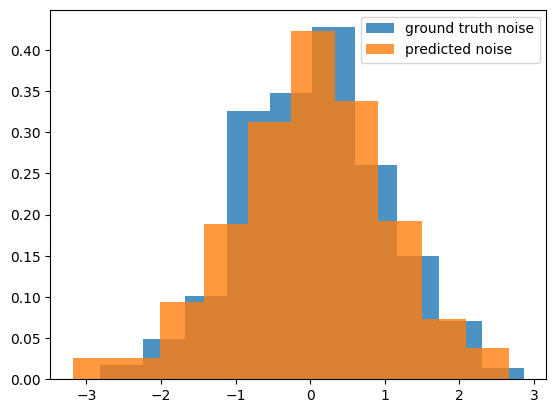

---
Epoch: 1500 | Train Loss 0.41811883449554443


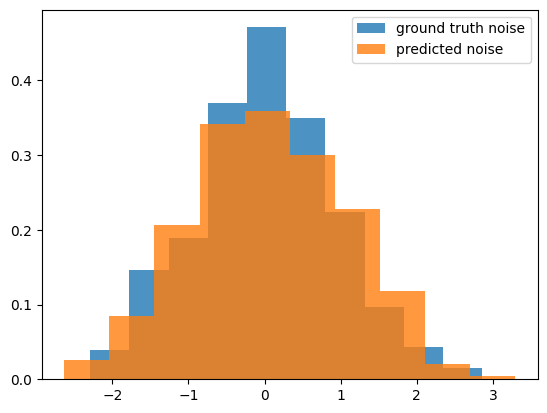

---
Epoch: 2000 | Train Loss 0.1561509221792221


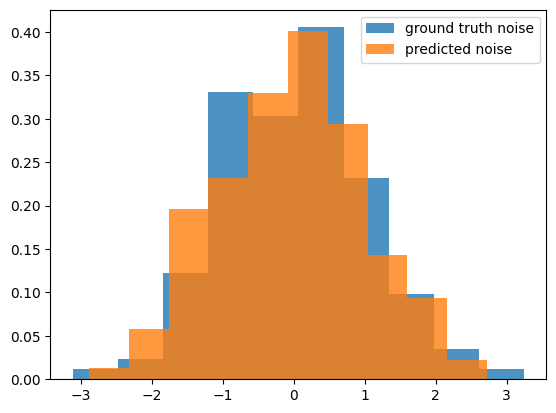

---
Epoch: 2500 | Train Loss 0.1089414656162262


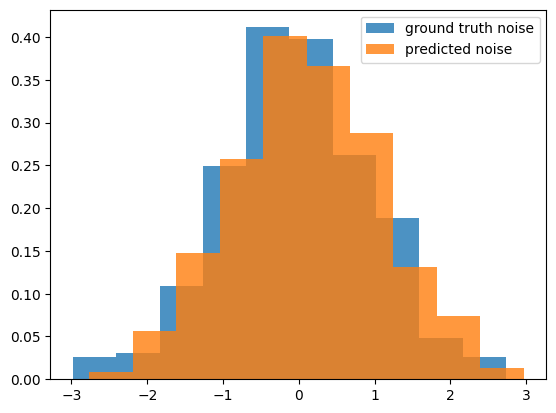

---
Epoch: 3000 | Train Loss 0.16458149254322052


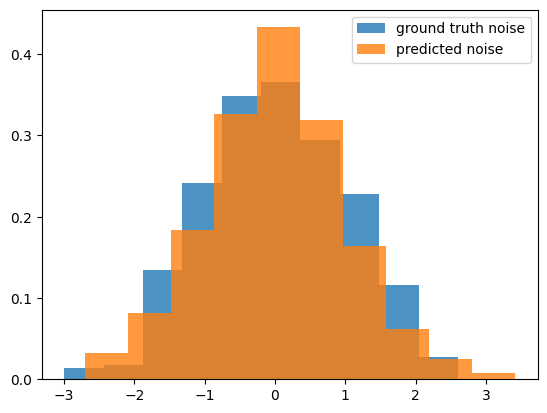

---
Epoch: 3500 | Train Loss 0.10332688689231873


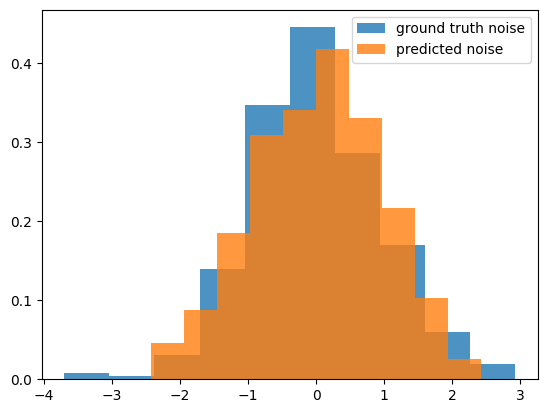

---
Epoch: 4000 | Train Loss 0.015014246106147766


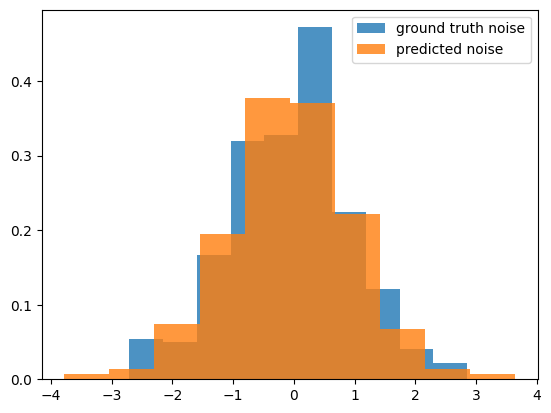

---
Epoch: 4500 | Train Loss 0.037463560700416565


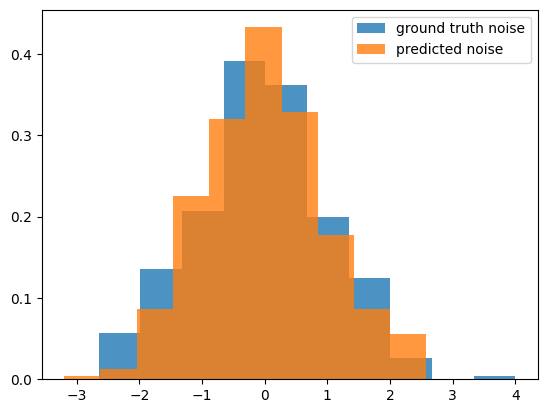

In [48]:
for epoch in range(5000):
    mean_epoch_loss = []
    
    batch = torch.stack([inp] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device) 

    #predicted_noise = unet(batch_noisy, t)
    z , z_mu, z_var = unet(batch_noisy, t)

    predicted_noise = z
    
    optimizer.zero_grad()
    #print('noise',noise)
    #print('predicted_noise',predicted_noise)
    kld = torch.mean(-0.5 * torch.sum(1 + z_var - z_mu ** 2 - z_var.exp(), dim = 1), dim = 0)
    loss = kld #kl_divergence(z , z_mu, z_var) #torch.nn.functional.mse_loss(noise, predicted_noise) 
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                #plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

In [49]:
with torch.no_grad():
    img = torch.randn(200).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            print('i',i)
            print(img)

i 250
tensor([[ 2.0669e+00, -2.4206e+00,  5.8005e-01,  4.5778e+00,  9.9723e-01,
          9.0094e-01,  1.0216e+00, -9.9107e-01, -1.5655e+00, -2.2674e+00,
          5.5236e-01, -3.0585e-01, -2.7445e-01,  7.0146e-01, -7.5525e-01,
         -1.3270e+00,  9.4497e-01,  1.4703e-01,  2.2280e+00,  1.0640e+00,
          2.5180e+00, -1.6564e+00, -1.2481e+00,  1.5431e-01, -4.2329e+00,
         -1.8951e+00,  1.3151e+00,  5.0288e+00, -7.9642e-01, -2.6975e+00,
          2.5295e+00, -3.5201e+00,  1.3684e+00,  3.4829e-01, -1.0591e+00,
          1.1049e+00, -2.3734e+00, -1.4114e-01, -1.8937e+00, -2.1308e+00,
          4.3112e-01, -2.6030e+00,  1.4298e+00,  3.3255e+00, -2.7664e+00,
          8.1287e-01, -2.2869e-02, -5.5853e-01,  1.3397e+00,  9.2736e-01,
          4.0916e-01,  2.4365e+00, -8.7872e-01, -3.3502e-02,  2.0772e+00,
          1.4928e+00,  2.8774e+00, -1.6450e-01,  2.2163e+00,  4.3869e+00,
         -2.1434e+00, -7.2046e-01, -8.7947e-01,  1.1160e+00,  2.6809e-03,
          2.0970e+00,  3.9115e-0